In [2]:
import geopandas as gpd
import rasterio
from rasterio.features import rasterize
from shapely.geometry import mapping
import numpy as np
from PIL import Image
import os
import logging


In [16]:
input_geojson_path = "/Users/mischabauckhage/Documents/ETH/02_Master/3_Semester/GMP2/gmp2/01_Segmentation/output/old_national_1975_skeleton.geojson"
output_tiff_path = "/Users/mischabauckhage/Documents/ETH/02_Master/3_Semester/GMP2/gmp2/02_DEM/output/height_map_old_national_1975.png"
output_png_path = "output/"
height_attribute = "height"
input_crs = "EPSG:2056"
resolution = 0.5

In [ ]:
import numpy as np
import rasterio
from rasterio.features import rasterize
from shapely.geometry import mapping
import geopandas as gpd

# Load the GeoDataFrame
gdf = gpd.read_file(input_geojson_path)



# Select only the 'height' attribute and the geometry
gdf = gdf[['height', 'geometry']]
# Check validity of each geometry
gdf['is_valid'] = gdf['geometry'].is_valid


# Show all invalid geometries
invalid_geometries = gdf[~gdf['is_valid']]
print(invalid_geometries)

# Remove all features that have 'is_valid' == False
gdf = gdf[gdf['is_valid']]

gdf.head()




In [ ]:
#gdf = gdf.to_crs(epsg=2056)

# Verify if all geometries are now valid
print(gdf['is_valid'].all())  # Should return True if all geometries are valid


# Get the total bounds of the geometries
minx, miny, maxx, maxy = gdf.total_bounds
print(minx, miny, maxx, maxy)

gdf.head()

In [32]:

# Define the output raster dimensions (based on the resolution)

width = int((maxx - minx) / resolution)
height = int((maxy - miny) / resolution)

# Create an affine transform for the raster
transform = rasterio.transform.from_bounds(minx, miny, maxx, maxy, width, height)

# Create an empty array to store the raster data
raster = np.zeros((height, width), dtype=rasterio.float32)



# Prepare geometries and corresponding 'hoehe' values for rasterization
shapes = ((mapping(geom), value) for geom, value in zip(gdf.geometry, gdf[height_attribute]))

# Rasterize the geometries using the 'hoehe' values
raster = rasterize(
    shapes=shapes,
    out_shape=raster.shape,
    transform=transform,
    fill=0,  # Background value
    dtype=rasterio.float32
)

# At this point, 'raster' contains the rasterized data


In [ ]:
from PIL import Image
import cv2

def convert_tif_to_png(input_tif_path, output_png_path):
    # Load the TIF image using OpenCV
    tif_image = cv2.imread(input_tif_path, cv2.IMREAD_UNCHANGED)

    if tif_image is None:
        print(f"Failed to load TIFF file: {input_tif_path}")
        return False

    # Convert the TIF image to PNG using OpenCV
    success = cv2.imwrite(output_png_path, tif_image)

    if success:
        print(f"Successfully converted {input_tif_path} to {output_png_path}")
    else:
        print(f"Failed to convert {input_tif_path} to PNG.")

    return success

# Example usage
input_tif = 'D:\mbauckhage\gmp2\00_Transfer\dhm25.tif'
output_png = 'D:\mbauckhage\gmp2\00_Transfer\dhm25.png'
convert_tif_to_png(input_tif, output_png)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Create a sample NumPy array
array = np.random.rand(10, 10).astype('float32')


# Flip the array horizontally
flipped_array = np.flipud(array)

# Plot the original and flipped arrays
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(array, cmap='viridis')
axes[0].set_title('Original Array')

axes[1].imshow(flipped_array, cmap='viridis')
axes[1].set_title('Flipped Array')

plt.show()

# Define the file paths
original_tif_path = "original_array.tif"
flipped_tif_path = "flipped_array.tif"

# Define the transform for EPSG:2056 with bottom left pixel at (2600000, 1500000)
transform_epsg2056 = from_origin(2569000, 1183000 + array.shape[0], 1, -1)

# Ensure the arrays are 2-dimensional
array = array.squeeze()
flipped_array = flipped_array.squeeze()

import rasterio
from rasterio.transform import from_origin

# Define the file paths
original_tif_path = "original_array.tif"
flipped_tif_path = "flipped_array.tif"

# Define the transform for EPSG:2056 with bottom left pixel at (2600000, 1500000)
transform_epsg2056 = from_origin(2569000, 1183000 + array.shape[0], 1, -1)

# Ensure the arrays are 2-dimensional
array = array.squeeze()
flipped_array = flipped_array.squeeze()

# Save the original array as a TIFF file with EPSG:2056
with rasterio.open(
    original_tif_path,
    'w',
    driver='GTiff',
    height=array.shape[0],
    width=array.shape[1],
    count=1,
    dtype='float32',
    crs='EPSG:2056',
    transform=transform_epsg2056,
) as dst:
    dst.write(array, 1)

# Save the flipped array as a TIFF file with EPSG:2056
with rasterio.open(
    flipped_tif_path,
    'w',
    driver='GTiff',
    height=flipped_array.shape[0],
    width=flipped_array.shape[1],
    count=1,
    dtype='float32',
    crs='EPSG:2056',
    transform=transform_epsg2056,
) as dst:
    dst.write(flipped_array, 1)

In [ ]:


print(f"Original array saved to {original_tif_path} with EPSG:2056")
print(f"Flipped array saved to {flipped_tif_path} with EPSG:2056")


from utils.dem import create_tiles

input = "/Users/mischabauckhage/Documents/ETH/02_Master/3_Semester/GMP2/gmp2/02_DEM/flipped_array.tif"
output_png_path = "tests"

create_tiles(input, output_png_path, tile_size=2, img_format="tif",min_nonzero_value=0)

In [1]:
from utils.dem import create_tiles

input = "/Users/mischabauckhage/Documents/ETH/02_Master/3_Semester/GMP2/gmp2/02_DEM/split_merge_test/extracted_band.tif"
output_png_path = "split_merge_test/tiles"

create_tiles(input, output_png_path, tile_size=10, img_format="tif",min_nonzero_value=0, input_crs="EPSG:21781")

Processing tile (0, 0): (0, 10), (0, 10)
Tile size in meters: 25.0 x 25.0
Processing tile (1, 0): (10, 20), (0, 10)
Tile size in meters: 25.0 x 25.0
Processing tile (2, 0): (20, 28), (0, 10)
Tile size in meters: 25.0 x 25.0
Processing tile (0, 1): (0, 10), (10, 20)
Tile size in meters: 25.0 x 25.0
Processing tile (1, 1): (10, 20), (10, 20)
Tile size in meters: 25.0 x 25.0
Processing tile (2, 1): (20, 28), (10, 20)
Tile size in meters: 25.0 x 25.0
Processing tile (0, 2): (0, 10), (20, 30)
Tile size in meters: 25.0 x 25.0
Processing tile (1, 2): (10, 20), (20, 30)
Tile size in meters: 25.0 x 25.0
Processing tile (2, 2): (20, 28), (20, 30)
Tile size in meters: 25.0 x 25.0
Processing tile (0, 3): (0, 10), (30, 34)
Tile size in meters: 25.0 x 25.0
Processing tile (1, 3): (10, 20), (30, 34)
Tile size in meters: 25.0 x 25.0
Processing tile (2, 3): (20, 28), (30, 34)
Tile size in meters: 25.0 x 25.0
Tiles saved to split_merge_test/tiles


In [ ]:
import rasterio

# Define the input and output file paths
input_tif_path = input
output_tif_path = 'split_merge_test/extracted_band.tif'

# Open the input TIFF file
with rasterio.open(input_tif_path) as src:
    # Read the first band
    first_band = src.read(1)
    
    # Get the metadata of the input file
    meta = src.meta
    
    # Update the metadata to reflect the number of layers
    meta.update(count=1)

# Write the first band to a new TIFF file
with rasterio.open(output_tif_path, 'w', **meta) as dst:
    dst.write(first_band, 1)

print(f"First band extracted and saved to {output_tif_path}")

In [5]:
import numpy as np
import rasterio
from rasterio.transform import from_origin

import matplotlib.pyplot as plt

# Define the file paths
png_path = "/Users/mischabauckhage/Documents/ETH/02_Master/3_Semester/GMP2/gmp2/00_Transfer/tiles_height_map_old_national_1975_20241025_130423/tile_0_0.tif"
png_path = "/Users/mischabauckhage/Documents/ETH/02_Master/3_Semester/GMP2/gmp2/00_Transfer/tiles_height_map_old_national_1975_20241025_130647_unity_tiles/height_map_tile_0_0.tif"


In [9]:
import rasterio

# Open the PNG file using rasterio
with rasterio.open(png_path) as src:
    # Get the transform which contains the origin coordinates
    transform = src.transform
    origin_x, origin_y = transform * (0, 0)

print(f"Origin coordinates: ({origin_x}, {origin_y})")

Origin coordinates: (2581552.698868844, 1195148.8543583471)


In [8]:
import rasterio
import numpy as np

# Define the file paths
first_tif_path = "/Users/mischabauckhage/Documents/ETH/02_Master/3_Semester/GMP2/gmp2/00_Transfer/tiles_height_map_old_national_1975_20241025_130423/tile_0_0.tif"
second_tif_path = "/Users/mischabauckhage/Documents/ETH/02_Master/3_Semester/GMP2/gmp2/00_Transfer/tiles_height_map_old_national_1975_20241025_130647_unity_tiles/height_map_tile_0_0.tif"
updated_tif_path = "/Users/mischabauckhage/Documents/ETH/02_Master/3_Semester/GMP2/gmp2/00_Transfer/tiles_height_map_old_national_1975_20241025_130647_unity_tiles/updated_height_map_tile_0_0.tif"

# Open the first TIFF file to get its transform
with rasterio.open(first_tif_path) as src1:
    first_transform = src1.transform
    first_crs = src1.crs  # Get the CRS

# Open the second TIFF file to read its data
with rasterio.open(second_tif_path) as src2:
    data = src2.read(1)  # Read the first band

# Create a new TIFF file with the updated transform
with rasterio.open(
        updated_tif_path,
        'w',
        driver='GTiff',
        height=data.shape[0],
        width=data.shape[1],
        count=1,
        dtype=data.dtype,
        crs=first_crs,  # Use the same CRS as the first TIFF
        transform=first_transform
) as dst:
    dst.write(data, 1)  # Write the data to the new TIFF

print(f"Updated TIFF saved as {updated_tif_path} with the transform from {first_tif_path}.")


Updated TIFF saved as /Users/mischabauckhage/Documents/ETH/02_Master/3_Semester/GMP2/gmp2/00_Transfer/tiles_height_map_old_national_1975_20241025_130647_unity_tiles/updated_height_map_tile_0_0.tif with the transform from /Users/mischabauckhage/Documents/ETH/02_Master/3_Semester/GMP2/gmp2/00_Transfer/tiles_height_map_old_national_1975_20241025_130423/tile_0_0.tif.


In [17]:
import os
import rasterio

# Define the directories
reference_dir = "/Users/mischabauckhage/Documents/ETH/02_Master/3_Semester/GMP2/gmp2/00_Transfer/tiles_height_map_old_national_1975_20241025_130423/"
input_dir = "/Users/mischabauckhage/Documents/ETH/02_Master/3_Semester/GMP2/gmp2/00_Transfer/tiles_height_map_old_national_1975_20241025_130647_unity_tiles/"
output_dir = "/Users/mischabauckhage/Documents/ETH/02_Master/3_Semester/GMP2/gmp2/00_Transfer/tiles_height_map_updated/"


def set_crs_for_tiles(reference_dir, input_dir, output_dir):
    # Create output folder if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Loop through all TIFF files in the reference directory
    for filename in os.listdir(reference_dir):
        if filename.endswith(".tif"):  # Check for TIFF files
            # Get the corresponding TIFF file in the input directory
            cor_filename = filename.replace("tile", "height_map_tile")
            corresponding_input_file = os.path.join(input_dir, cor_filename)
            
            # Check if the corresponding input file exists
            if os.path.exists(corresponding_input_file):
                # Open the reference TIFF file to get its transform and CRS
                with rasterio.open(os.path.join(reference_dir, filename)) as src1:
                    reference_transform = src1.transform
                    reference_crs = src1.crs  # Get the CRS

                # Open the corresponding TIFF file to read its data
                with rasterio.open(corresponding_input_file) as src2:
                    data = src2.read(1)  # Read the first band
                    

                # Create a new TIFF file with the updated transform
                updated_tif_path = os.path.join(output_dir, f"updated_{filename}")
                with rasterio.open(
                        updated_tif_path,
                        'w',
                        driver='GTiff',
                        height=data.shape[0],
                        width=data.shape[1],
                        count=1,
                        dtype=data.dtype,
                        crs=reference_crs,  # Use the same CRS as the reference TIFF
                        transform=reference_transform
                ) as dst:
                    dst.write(data, 1)  # Write the data to the new TIFF

                print(f"Updated {filename} saved as {updated_tif_path}")
            else:
                print(f"Corresponding file for {filename} not found in input directory.")

    print("All TIFF files have been updated successfully.")


Updated tile_6_2.tif saved as /Users/mischabauckhage/Documents/ETH/02_Master/3_Semester/GMP2/gmp2/00_Transfer/tiles_height_map_updated/updated_tile_6_2.tif
Updated tile_4_0.tif saved as /Users/mischabauckhage/Documents/ETH/02_Master/3_Semester/GMP2/gmp2/00_Transfer/tiles_height_map_updated/updated_tile_4_0.tif
Updated tile_2_6.tif saved as /Users/mischabauckhage/Documents/ETH/02_Master/3_Semester/GMP2/gmp2/00_Transfer/tiles_height_map_updated/updated_tile_2_6.tif
Updated tile_0_4.tif saved as /Users/mischabauckhage/Documents/ETH/02_Master/3_Semester/GMP2/gmp2/00_Transfer/tiles_height_map_updated/updated_tile_0_4.tif
Updated tile_0_13.tif saved as /Users/mischabauckhage/Documents/ETH/02_Master/3_Semester/GMP2/gmp2/00_Transfer/tiles_height_map_updated/updated_tile_0_13.tif
Updated tile_0_12.tif saved as /Users/mischabauckhage/Documents/ETH/02_Master/3_Semester/GMP2/gmp2/00_Transfer/tiles_height_map_updated/updated_tile_0_12.tif
Updated tile_0_5.tif saved as /Users/mischabauckhage/Documen

In [20]:
import os
import rasterio
from rasterio.enums import Resampling
import numpy as np
from PIL import Image

def rotate_and_flip_tif(input_folder, output_folder):
    # Create output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)

    # Loop through all TIFF files in the input directory
    for filename in os.listdir(input_folder):
        if filename.endswith(".tif"):  # Check for TIFF files
            input_tif_path = os.path.join(input_folder, filename)
            output_tif_path = os.path.join(output_folder, filename)

            # Open the input TIFF file
            with rasterio.open(input_tif_path) as src:
                # Read the data
                data = src.read(1)

                # Rotate the data by 270 degrees
                rotated_data = np.rot90(data, k=1)

                # Flip the data
                flipped_data = np.flipud(rotated_data)

                # Update the metadata to reflect the new dimensions
                meta = src.meta.copy()
                meta.update({
                    "height": flipped_data.shape[0],
                    "width": flipped_data.shape[1],
                    "transform": rasterio.transform.from_bounds(
                        src.bounds.left, src.bounds.bottom, src.bounds.right, src.bounds.top,
                        flipped_data.shape[1], flipped_data.shape[0]
                    )
                })

                # Write the rotated and flipped data to a new TIFF file
                with rasterio.open(output_tif_path, 'w', **meta) as dst:
                    dst.write(flipped_data, 1)

            print(f"Processed {filename} and saved to {output_tif_path}")



In [21]:
# Define the input and output directories
input_folder = "/Users/mischabauckhage/Documents/ETH/02_Master/3_Semester/GMP2/gmp2/00_Transfer/tiles_height_map_updated"
output_folder = "/Users/mischabauckhage/Documents/ETH/02_Master/3_Semester/GMP2/gmp2/00_Transfer/tiles_height_map_updated_fliped"

# Run the function
rotate_and_flip_tif(input_folder, output_folder)

Processed updated_tile_4_15.tif and saved to /Users/mischabauckhage/Documents/ETH/02_Master/3_Semester/GMP2/gmp2/00_Transfer/tiles_height_map_updated_fliped/updated_tile_4_15.tif
Processed updated_tile_1_0.tif and saved to /Users/mischabauckhage/Documents/ETH/02_Master/3_Semester/GMP2/gmp2/00_Transfer/tiles_height_map_updated_fliped/updated_tile_1_0.tif
Processed updated_tile_11_15.tif and saved to /Users/mischabauckhage/Documents/ETH/02_Master/3_Semester/GMP2/gmp2/00_Transfer/tiles_height_map_updated_fliped/updated_tile_11_15.tif
Processed updated_tile_3_2.tif and saved to /Users/mischabauckhage/Documents/ETH/02_Master/3_Semester/GMP2/gmp2/00_Transfer/tiles_height_map_updated_fliped/updated_tile_3_2.tif
Processed updated_tile_5_4.tif and saved to /Users/mischabauckhage/Documents/ETH/02_Master/3_Semester/GMP2/gmp2/00_Transfer/tiles_height_map_updated_fliped/updated_tile_5_4.tif
Processed updated_tile_8_15.tif and saved to /Users/mischabauckhage/Documents/ETH/02_Master/3_Semester/GMP2/g

In [5]:
import rasterio
from rasterio.merge import merge
import os
from PIL import Image

def stitch_tifs_to_png(input_folder, output_png_path):
    # List to store the opened TIFF files
    tifs = []

    # Loop through all TIFF files in the input directory
    for filename in os.listdir(input_folder):
        if filename.endswith(".tif"):  # Check for TIFF files
            tif_path = os.path.join(input_folder, filename)
            src = rasterio.open(tif_path)
            tifs.append(src)

    # Merge the TIFF files
    mosaic, out_trans = merge(tifs)

    # Close the opened TIFF files
    for src in tifs:
        src.close()

    # Convert the mosaic to an image
    mosaic_image = Image.fromarray(mosaic[0])

    # Save the image as a PNG
    mosaic_image.save(output_png_path)
    print(f"Stitched image saved as {output_png_path}")



In [6]:
# Define the input folder and output PNG path
input_folder = "/Users/mischabauckhage/Documents/ETH/02_Master/3_Semester/GMP2/gmp2/00_Transfer/tiles_height_map_updated_fliped"
output_png_path = "stitched_image.png"

# Run the function
stitch_tifs_to_png(input_folder, output_png_path)

WindowError: Bounds and transform are inconsistent

In [13]:
from datetime import datetime
import logging
# Setup logging
# -----------------------------------------------
log_directory = "/Users/mischabauckhage/Documents/ETH/02_Master/3_Semester/GMP2/gmp2/logs/dem/"

log_file = os.path.join(log_directory, f"preprocessing_{datetime.now().strftime('%Y%m%d_%H%M%S')}.log")

logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler(log_file),
        logging.StreamHandler()
    ]
)

In [14]:
import rasterio
import os

def print_crs_for_all_tifs(input_folder):
    # Track base CRS and transform for potential consistency checks if needed
    base_crs = None
    base_transform = None
    all_consistent = True

    # Loop through all TIFF files in the input directory
    for filename in os.listdir(input_folder):
        if filename.endswith(".tif"):  # Check for TIFF files
            tif_path = os.path.join(input_folder, filename)
            with rasterio.open(tif_path) as src:
                # Print the filename and CRS of each file
                logging.info(f"File: {filename}")
                logging.info(f"  CRS: {src.crs}")
                #print(f"  Transform: {src.transform}\n")

                # Set the CRS and transform of the first file as the base reference
                if base_crs is None and base_transform is None:
                    base_crs = src.crs
                    base_transform = src.transform
                else:
                    # Check if current file's CRS or transform differs from the base
                    if src.crs != base_crs or src.transform != base_transform:
                        all_consistent = False
                        #print(f"  --> Inconsistent with the base file CRS or transform.\n")

    # Final message
    if all_consistent:
        print("All files have consistent CRS and transform.")
    else:
        print("Some files have inconsistent CRS or transform.")





In [15]:


# Define the input directory
input_folder = "/Users/mischabauckhage/Documents/ETH/02_Master/3_Semester/GMP2/gmp2/00_Transfer/tiles_height_map_updated_fliped"

# Run the function
print_crs_for_all_tifs(input_folder)

2024-10-25 17:01:11,233 - root - INFO - File: updated_tile_4_15.tif
2024-10-25 17:01:11,234 - root - INFO -   CRS: EPSG:2056
2024-10-25 17:01:11,239 - root - INFO - File: updated_tile_1_0.tif
2024-10-25 17:01:11,240 - root - INFO -   CRS: EPSG:2056
2024-10-25 17:01:11,244 - root - INFO - File: updated_tile_11_15.tif
2024-10-25 17:01:11,246 - root - INFO -   CRS: EPSG:2056
2024-10-25 17:01:11,250 - root - INFO - File: updated_tile_3_2.tif
2024-10-25 17:01:11,251 - root - INFO -   CRS: EPSG:2056
2024-10-25 17:01:11,254 - root - INFO - File: updated_tile_5_4.tif
2024-10-25 17:01:11,255 - root - INFO -   CRS: EPSG:2056
2024-10-25 17:01:11,259 - root - INFO - File: updated_tile_8_15.tif
2024-10-25 17:01:11,261 - root - INFO -   CRS: EPSG:2056
2024-10-25 17:01:11,264 - root - INFO - File: updated_tile_6_10.tif
2024-10-25 17:01:11,265 - root - INFO -   CRS: EPSG:2056
2024-10-25 17:01:11,269 - root - INFO - File: updated_tile_9_9.tif
2024-10-25 17:01:11,270 - root - INFO -   CRS: EPSG:2056
202

Some files have inconsistent CRS or transform.


In [3]:
from PIL import Image

def reduce_png_size(input_png_path, output_png_path, quality=5):
    # Open the PNG file
    with Image.open(input_png_path) as img:
        # Save the image with reduced quality
        img.save(output_png_path, "PNG", optimize=True, quality=quality)
        print(f"Reduced file size and saved to {output_png_path}")

# Example usage
input_png_path = "/Users/mischabauckhage/Documents/ETH/02_Master/3_Semester/GMP2/gmp2/02_DEM/output/final_dem_1975.png"
output_png_path = "/Users/mischabauckhage/Documents/ETH/02_Master/3_Semester/GMP2/gmp2/02_DEM/output/final_dem_1975_reduced_size.png"
reduce_png_size(input_png_path, output_png_path)

Reduced file size and saved to /Users/mischabauckhage/Documents/ETH/02_Master/3_Semester/GMP2/gmp2/02_DEM/output/final_dem_1975_reduced_size.png


In [10]:
from PIL import Image

input_png_path = "/Users/mischabauckhage/Documents/ETH/02_Master/3_Semester/GMP2/gmp2/02_DEM/output/final_dem_1975.png"

def extract_extent(input_png_path, output_png_path, left, upper, right, lower):
    # Open the PNG file
    with Image.open(input_png_path) as img:
        # Crop the image to the specified extent
        cropped_img = img.crop((left, upper, right, lower))
        # Save the cropped image
        cropped_img.save(output_png_path)
        print(f"Extracted extent and saved to {output_png_path}")

# Example usage
left, upper, right, lower = 6000, 4000, 8000, 6000
output_cropped_png_path = "/Users/mischabauckhage/Documents/ETH/02_Master/3_Semester/GMP2/gmp2/02_DEM/output/final_dem_1975_cropped.png"
extract_extent(input_png_path, output_cropped_png_path, left, upper, right, lower)

Extracted extent and saved to /Users/mischabauckhage/Documents/ETH/02_Master/3_Semester/GMP2/gmp2/02_DEM/output/final_dem_1975_cropped.png


In [ ]:
import numpy as np
import os
from PIL import Image
import logging

def stitch_tiles(input_dir, output_image, tile_size=512, overlap=256):
    # Gather all tile file names
    tile_files = sorted([f for f in os.listdir(input_dir) if f.endswith('.png')])

    # Calculate the dimensions of the stitched image based on the number of tiles
    num_tiles_x = len(set(int(f.split('_')[2]) for f in tile_files))  # assuming file names are like 'tile_y_x.png'
    num_tiles_y = len(set(int(f.split('_')[1]) for f in tile_files))

    # Calculate final dimensions of the stitched image
    stitched_width = (num_tiles_x - 1) * (tile_size - overlap) + tile_size
    stitched_height = (num_tiles_y - 1) * (tile_size - overlap) + tile_size

    # Initialize the cumulative array and count array for averaging
    cumulative_array = np.zeros((stitched_height, stitched_width), dtype=np.float32)
    count_array = np.zeros((stitched_height, stitched_width), dtype=np.float32)

    # Loop over each tile and place it on the stitched canvas
    for tile_file in tile_files:
        # Extract tile position from the filename
        tile_y, tile_x = map(int, tile_file.split('_')[1:3])  # assuming 'tile_y_x.png' format
        
        # Load tile image
        tile_path = os.path.join(input_dir, tile_file)
        tile = np.array(Image.open(tile_path))

        # Calculate the position on the stitched image
        start_x = tile_x * (tile_size - overlap)
        start_y = tile_y * (tile_size - overlap)
        end_x = start_x + tile_size
        end_y = start_y + tile_size

        # Add the tile to the cumulative array and increment the count array
        cumulative_array[start_y:end_y, start_x:end_x] += tile
        count_array[start_y:end_y, start_x:end_x] += 1

        logging.info(f"Added tile ({tile_y}, {tile_x}) at ({start_y}, {end_y}), ({start_x}, {end_x})")

    # Compute the averaged image by dividing cumulative array by the count array
    stitched_image = np.divide(
        cumulative_array, count_array, out=np.zeros_like(cumulative_array), where=(count_array != 0)
    ).astype(np.uint8)

    # Save the final stitched image
    stitched_img = Image.fromarray(stitched_image, mode='L')
    stitched_img.save(output_image)
    logging.info(f"Stitched image saved as {output_image}")



In [17]:
import numpy as np
import os
from PIL import Image
import logging
from tqdm import tqdm
import re

def stitch_alternate_tiles(input_dir, output_image, tile_size=512, overlap=256, filename_starts_with='updated_tile'):
    # Gather all tile file names
    tile_files = sorted([
        f for f in os.listdir(input_dir) 
        if f.startswith(filename_starts_with) and (f.endswith('.png') or f.endswith('.jpg') or f.endswith('.tif') or f.endswith('.tiff'))
    ])
    logging.info(f"Found {len(tile_files)} tile files in the input directory")

    # Pattern to extract y and x indices from filenames like 'updated_tile_y_x.png'
    tile_pattern = re.compile(rf"{filename_starts_with}_(\d+)_(\d+)\.(?:png|jpg|tif|tiff)")
    
    # Filter tile_files based on matching the pattern
    valid_tile_files = [f for f in tile_files if tile_pattern.match(f)]
    logging.info(f"Valid tile files after filtering: {len(valid_tile_files)}")
    
    # Pattern to extract y and x indices from filenames like 'updated_tile_y_x.png'
    tile_pattern = re.compile(rf"{filename_starts_with}_(\d+)_(\d+)\.(?:png|jpg|tif|tiff)")
    
    # Filter tile_files based on matching the pattern
    valid_tile_files = [f for f in tile_files if tile_pattern.match(f)]
    logging.info(f"Valid tile files after filtering: {len(valid_tile_files)}")
    
    # Calculate the number of tiles in x and y based on unique indices in filenames
    y_indices = {int(tile_pattern.match(f).group(1)) for f in valid_tile_files}
    x_indices = {int(tile_pattern.match(f).group(2)) for f in valid_tile_files}
    
    num_tiles_x = len(x_indices)
    num_tiles_y = len(y_indices)
    
    # Calculate final dimensions of the stitched image
    stitched_width = (num_tiles_x // 2) * tile_size
    stitched_height = (num_tiles_y // 2) * tile_size

    # Initialize arrays for each stitched version
    stitched_set1 = np.zeros((stitched_height, stitched_width), dtype=np.float32)
    stitched_set2 = np.zeros((stitched_height, stitched_width), dtype=np.float32)
    count_array1 = np.zeros((stitched_height, stitched_width), dtype=np.float32)
    count_array2 = np.zeros((stitched_height, stitched_width), dtype=np.float32)

    # Separate files into two sets based on even and odd indices
    set1_tiles = [f for f in valid_tile_files if int(tile_pattern.match(f).group(1)) % 2 == 0 and int(tile_pattern.match(f).group(2)) % 2 == 0]
    set2_tiles = [f for f in valid_tile_files if int(tile_pattern.match(f).group(1)) % 2 == 1 and int(tile_pattern.match(f).group(2)) % 2 == 1]


    # Stitch set 1 (every second tile in x and y directions)
    for tile_file in tqdm(set1_tiles, desc="Stitching Set 1"):
        logging.info(f"Set 1: Processing {tile_file}")
        tile_y, tile_x = map(int, os.path.splitext(tile_file)[0].split('_')[2:4])
        start_x, start_y = (tile_x // 2) * tile_size, (tile_y // 2) * tile_size
        
        tile = np.array(Image.open(os.path.join(input_dir, tile_file)))
        stitched_set1[start_y:start_y + tile_size, start_x:start_x + tile_size] += tile
        count_array1[start_y:start_y + tile_size, start_x:start_x + tile_size] += 1

    # Stitch set 2 (remaining alternate tiles)
    for tile_file in tqdm(set2_tiles, desc="Stitching Set 2"):
        logging.info(f"Set 2: Processing {tile_file}")
        tile_y, tile_x = map(int, os.path.splitext(tile_file)[0].split('_')[2:4])
        start_x, start_y = ((tile_x - 1) // 2) * tile_size, ((tile_y - 1) // 2) * tile_size
        
        tile = np.array(Image.open(os.path.join(input_dir, tile_file)))
        stitched_set2[start_y:start_y + tile_size, start_x:start_x + tile_size] += tile
        count_array2[start_y:start_y + tile_size, start_x:start_x + tile_size] += 1
        
    # Save the first stitched set
    stitched_img_set1 = Image.fromarray(stitched_set1.astype(np.uint8), mode='L')
    stitched_img_set1.save(output_image.replace('.png', '_set1.png'))
    logging.info(f"Stitched set 1 image saved as {output_image.replace('.png', '_set1.png')}")

    # Save the second stitched set
    stitched_img_set2 = Image.fromarray(stitched_set2.astype(np.uint8), mode='L')
    stitched_img_set2.save(output_image.replace('.png', '_set2.png'))
    logging.info(f"Stitched set 2 image saved as {output_image.replace('.png', '_set2.png')}")

    # Take the average of both sets where there is overlap
    averaged_stitched_image = np.divide(
        stitched_set1 + stitched_set2,
        count_array1 + count_array2,
        out=np.zeros_like(stitched_set1),
        where=(count_array1 + count_array2) != 0
    ).astype(np.uint8)

    # Save the final stitched image
    stitched_img = Image.fromarray(averaged_stitched_image, mode='L')
    stitched_img.save(output_image)
    logging.info(f"Stitched image saved as {output_image}")


In [18]:
from datetime import datetime
# Define paths and parameters
# -----------------------------------------------
input_dir = "/Users/mischabauckhage/Documents/ETH/02_Master/3_Semester/GMP2/gmp2/00_Transfer/tiles_height_map_old_national_1975_20241031_153817/HeightMaps_crs_fix_flip"
output_image_path = f"/Users/mischabauckhage/Documents/ETH/02_Master/3_Semester/GMP2/gmp2/02_DEM/output/final_dem_1975_overlap_{datetime.now().strftime('%Y%m%d_%H%M%S')}.png"

stitch_alternate_tiles(input_dir, output_image_path, tile_size=512, overlap=256, filename_starts_with='updated_tile')


Stitching Set 2: 100%|██████████| 165/165 [00:00<00:00, 281.45it/s]


# Tiling and Stitching | Github Code

In [26]:
import numpy as np
from skimage.util import view_as_windows
from PIL import Image
import argparse

import pdb


def generate_tiling(image_path, w_size, normalize=True):
    # Generate tiling images
    win_size = w_size
    pad_px = win_size // 2

    # Read image
    in_img = np.array(Image.open(image_path))
    
    # normalize image
    if normalize:
        in_img = (in_img - in_img.min()) / (in_img.max() - in_img.min())
        in_img = (in_img * 255).astype(np.uint8)
    
    if len(in_img.shape) == 2:
        img_pad = np.pad(in_img, [(pad_px,pad_px), (pad_px,pad_px)], 'edge')
        tiles = view_as_windows(img_pad, (win_size,win_size), step=pad_px)
    else:
        img_pad = np.pad(in_img, [(pad_px,pad_px), (pad_px,pad_px), (0,0)], 'edge')
        tiles = view_as_windows(img_pad, (win_size,win_size,3), step=pad_px)
    tiles_lst = []
    for row in range(tiles.shape[0]):
        for col in range(tiles.shape[1]):
            if len(in_img.shape) == 2:
                tt = tiles[row, col, ...].copy()
            else:
                tt = tiles[row, col, 0, ...].copy()
            # If you want black boarder, set the value to 25 (Suggest not using balck boarder)
            # bordersize=1005
            # tt[:bordersize,:, 2] = 255
            # tt[-bordersize:,:, 2] = 255
            # tt[:,:bordersize, 2] = 255
            # tt[:,-bordersize:, 2] = 255
            # skio.imsave(os.path.join(save_image_path, f"t_r{row:02d}_c{col:02d}.jpg"), tt)
            tiles_lst.append(tt)
    return tiles_lst



In [27]:
input_path = "/Users/mischabauckhage/Documents/ETH/02_Master/3_Semester/GMP2/gmp2/02_DEM/output/height_map_old_national_1975.png"

tiles = generate_tiling(input_path, w_size=512)


In [28]:
def save_tiles(tiles, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for i, tile in enumerate(tiles):
        # Ensure the tile is in the correct format
        if tile.dtype != np.uint8:
            # Scale from [0, 1] or [0, max] to [0, 255]
            tile = (tile * 255).clip(0, 255).astype(np.uint8)

        tile_image = Image.fromarray(tile)  # Convert numpy array to PIL Image
        tile_path = os.path.join(output_dir, f'tile_{i:04d}.png')  # Generate unique file name
        tile_image.save(tile_path)  # Save the image as PNG


def read_tiles(input_dir):
    tile_images = []
    for filename in sorted(os.listdir(input_dir)):
        if filename.endswith('.png'):
            tile_path = os.path.join(input_dir, filename)
            tile_image = np.array(Image.open(tile_path))  # Read the image and convert to numpy array
            tile_images.append(tile_image)
    return tile_images

In [29]:
output_dir = f"/Users/mischabauckhage/Documents/ETH/02_Master/3_Semester/GMP2/gmp2/02_DEM/output/tiles_{datetime.now().strftime('%Y%m%d_%H%M%S')}/png"


# Save the tiles to the specified directory
save_tiles(tiles, output_dir)



First tile shape: (512, 512)


In [33]:
import numpy as np
from skimage.util import view_as_windows
from PIL import Image
import cv2

def generate_tiling(image_path, w_size):
    win_size = w_size
    pad_px = win_size // 2
    in_img = np.array(Image.open(image_path))

    if len(in_img.shape) == 2:
        img_pad = np.pad(in_img, [(pad_px, pad_px), (pad_px, pad_px)], 'edge')
        tiles = view_as_windows(img_pad, (win_size, win_size), step=pad_px)
    else:
        img_pad = np.pad(in_img, [(pad_px, pad_px), (pad_px, pad_px), (0, 0)], 'edge')
        tiles = view_as_windows(img_pad, (win_size, win_size, 3), step=pad_px)

    tiles_lst = []
    for row in range(tiles.shape[0]):
        for col in range(tiles.shape[1]):
            if len(in_img.shape) == 2:
                tt = tiles[row, col, ...].copy()
            else:
                tt = tiles[row, col, 0, ...].copy()
            tiles_lst.append(tt)
    return tiles_lst

def reconstruct_tiling(original_image_path, test_pred_dict, tile_save_path, w_size, image_debug=None, save_image=True):
    in_patches = list(test_pred_dict.keys())
    in_patches.sort()
    patches_images = list(test_pred_dict.values())

    # Convert patches_images to a numpy array
    patches_images = np.array(patches_images)

    win_size = w_size
    pad_px = win_size // 2

    in_img = np.array(Image.open(original_image_path).convert("RGB"))
    
    if in_img is None:
        print('original image {}'.format(original_image_path))

    new_img = reconstruct_from_patches(patches_images, win_size, pad_px, in_img.shape, np.float32)

    # If the image has more than one channel, only store the first channel
    if new_img.shape[-1] > 1:
        new_img = new_img[:, :, 0]
    if save_image:
        cv2.imwrite(tile_save_path, new_img)

    if image_debug is not None:
        cv2.imwrite(image_debug, new_img * 255)
    
    return new_img

def reconstruct_from_patches(patches_images, patch_size, step_size, image_size_2d, image_dtype):
    i_h, i_w = np.array(image_size_2d[:2]) + (patch_size, patch_size)
    p_h = p_w = patch_size

    # Initialize the reconstructed image array
    img = np.zeros((i_h + p_h // 2, i_w + p_w // 2, 3), dtype=image_dtype)

    numrows = (i_h) // step_size - 1
    numcols = (i_w) // step_size - 1
    expected_patches = numrows * numcols
    
    if patches_images.shape[0] != expected_patches:
        raise ValueError(f"Expected {expected_patches} patches, got {patches_images.shape[0]}")

    patch_offset = step_size // 2
    patch_inner = p_h - step_size
    
    for row in range(numrows):
        for col in range(numcols):
            tt = patches_images[row * numcols + col]
            tt_roi = tt[patch_offset:-patch_offset, patch_offset:-patch_offset]

            # Check if the patch is grayscale
            if len(tt.shape) == 2:  # Grayscale case
                tt_roi = np.stack((tt_roi,)*3, axis=-1)  # Convert to RGB by stacking

            img[row * step_size:row * step_size + patch_inner,
                col * step_size:col * step_size + patch_inner] = tt_roi

    return img[step_size // 2:-(patch_size + step_size // 2), step_size // 2:-(patch_size + step_size // 2), :]



In [34]:
from datetime import datetime
import os
# Define paths and parameters
# -----------------------------------------------
#image_path = "/Users/mischabauckhage/Documents/ETH/02_Master/3_Semester/GMP2/gmp2/00_Transfer/tiles_height_map_old_national_1975_20241031_153817/HeightMaps_crs_fix_flip"
reconstructed_image_path = f"/Users/mischabauckhage/Documents/ETH/02_Master/3_Semester/GMP2/gmp2/02_DEM/output/final_dem_1975_overlap_{datetime.now().strftime('%Y%m%d_%H%M%S')}.png"

original_image_path = "/Users/mischabauckhage/Documents/ETH/02_Master/3_Semester/GMP2/gmp2/02_DEM/output/height_map_old_national_1975.png"


input_dir = "/Users/mischabauckhage/Documents/ETH/02_Master/3_Semester/GMP2/gmp2/00_Transfer/tiles_20241101_103214/heightMaps_flip"

# Read the tiles back into a list of arrays
tiles_from_files = read_tiles(input_dir)

# Check the shape of the first tile
if tiles_from_files:
    print(f"First tile shape: {tiles_from_files[0].shape}")

tiles_array = np.array(tiles_from_files)
test_pred_dict = {i: tiles_from_files[i] for i in range(len(tiles_array))}

reconstructed_image = reconstruct_tiling(original_image_path, test_pred_dict, reconstructed_image_path, w_size=512)

First tile shape: (512, 512)


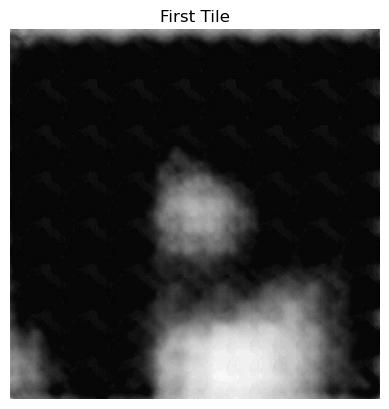

In [31]:
import matplotlib.pyplot as plt

# Plot the first tile from tiles_from_files
plt.imshow(tiles_from_files[0], cmap='gray')
plt.title('First Tile')
plt.axis('off')  # Hide the axis
plt.show()

In [32]:
from PIL import Image

# Extract the first channel
first_channel = reconstructed_image[:, :, 0].astype(np.uint8)

# Convert to a PIL Image
first_channel_image = Image.fromarray(first_channel)

# Define the output path
output_first_channel_path = "/Users/mischabauckhage/Documents/ETH/02_Master/3_Semester/GMP2/gmp2/02_DEM/output/first_channel.png"

# Save the image
first_channel_image.save(output_first_channel_path)
print(f"First channel saved as {output_first_channel_path}")

First channel saved as /Users/mischabauckhage/Documents/ETH/02_Master/3_Semester/GMP2/gmp2/02_DEM/output/first_channel.png


# Smoothing Heightmap

In [41]:
import cv2
import numpy as np
from PIL import Image

output_first_channel_path = "/Users/mischabauckhage/Documents/ETH/02_Master/3_Semester/GMP2/gmp2/02_DEM/output/final_dem_1975__20241101_134330.png"

# Read the first channel image from file
first_channel = np.array(Image.open(output_first_channel_path))

# Apply Gaussian blur to smooth the image
smoothed_image = cv2.GaussianBlur(first_channel, (99, 99), 0)

# Reduce the dimensions by half
height, width = smoothed_image.shape
reduced_image = cv2.resize(smoothed_image, (width // 3, height // 3), interpolation=cv2.INTER_AREA)

# Convert to PIL Image for saving or further processing
reduced_image_pil = Image.fromarray(reduced_image)

# Define the output path
output_reduced_image_path = "/Users/mischabauckhage/Documents/ETH/02_Master/3_Semester/GMP2/gmp2/02_DEM/output/reduced_smoothed_image.png"

# Save the reduced image
reduced_image_pil.save(output_reduced_image_path)
print(f"Reduced and smoothed image saved as {output_reduced_image_path}")

Reduced and smoothed image saved as /Users/mischabauckhage/Documents/ETH/02_Master/3_Semester/GMP2/gmp2/02_DEM/output/reduced_smoothed_image.png


In [43]:
from PIL import Image
import os

def convert_tif_to_png(input_tif_path, output_png_path):
    # Open the TIFF file
    with Image.open(input_tif_path) as img:
        # Convert the image to a mode supported by PNG
        if img.mode == 'F':
            img = img.convert('L')  # Convert to grayscale
        elif img.mode not in ['L', 'RGB']:
            img = img.convert('RGB')  # Convert to RGB if not already in a supported mode
        # Save the image as PNG
        img.save(output_png_path, "PNG")
        print(f"Converted {input_tif_path} to {output_png_path}")

# Example usage
input_tif_path = "/Users/mischabauckhage/Documents/ETH/02_Master/3_Semester/GMP2/gmp2/00_Data/DEM/dhm25.tif"
output_png_path = "/Users/mischabauckhage/Documents/ETH/02_Master/3_Semester/GMP2/gmp2/00_Data/DEM/dhm25.png"
convert_tif_to_png(input_tif_path, output_png_path)


Converted /Users/mischabauckhage/Documents/ETH/02_Master/3_Semester/GMP2/gmp2/00_Data/DEM/dhm25.tif to /Users/mischabauckhage/Documents/ETH/02_Master/3_Semester/GMP2/gmp2/00_Data/DEM/dhm25.png


In [1]:
import rasterio
import numpy as np

def make_tiff_square(input_tif_path, output_tif_path):
    with rasterio.open(input_tif_path) as src:
        data = src.read(1)  # Read the first band
        height, width = data.shape

        # Determine the size of the square
        size = max(height, width)

        # Create a new array with the square size and fill with zeros
        square_data = np.zeros((size, size), dtype=data.dtype)

        # Place the original data in the top-left corner of the square array
        square_data[:height, :width] = data

        # Update the metadata to reflect the new dimensions
        meta = src.meta.copy()
        meta.update({
            "height": size,
            "width": size,
            "transform": rasterio.transform.from_bounds(
                src.bounds.left, src.bounds.bottom, src.bounds.right, src.bounds.top,
                size, size
            )
        })

        # Write the square data to a new TIFF file
        with rasterio.open(output_tif_path, 'w', **meta) as dst:
            dst.write(square_data, 1)

# Example usage
input_tif_path = "/Users/mischabauckhage/Documents/ETH/02_Master/3_Semester/GMP2/gmp2/00_Data/processed_data/stiched_river_1975_clipped_depth.tif"
output_tif_path = "/Users/mischabauckhage/Documents/ETH/02_Master/3_Semester/GMP2/gmp2/00_Data/processed_data/stiched_river_1975_clipped_depth_squared.tif"
make_tiff_square(input_tif_path, output_tif_path)

In [10]:
import rasterio
from PIL import Image
import numpy as np

def clip_tif_to_png(input_tif_path, output_png_path, x_from, x_to, y_from, y_to):
    with rasterio.open(input_tif_path) as src:
        # Read the data
        data = src.read(1)  # Assuming single band TIFF

        # Clip the data
        clipped_data = data[y_from:y_to, x_from:x_to]

        # Normalize the clipped data to the range [0, 255]
        clipped_data = (clipped_data - clipped_data.min()) / (clipped_data.max() - clipped_data.min()) * 255
        clipped_data = clipped_data.astype(np.uint8)

        # Convert to PIL Image and save as PNG
        clipped_image = Image.fromarray(clipped_data)
        clipped_image.save(output_png_path)
        print(f"Clipped image saved as {output_png_path}")

# Example usage
input_tif_path = "/Users/mischabauckhage/Documents/ETH/02_Master/3_Semester/GMP2/gmp2/00_Data/processed_data/stiched_river_1975_clipped_depth.tif"
output_png_path = "/Users/mischabauckhage/Documents/ETH/02_Master/3_Semester/GMP2/gmp2/00_Data/processed_data/stiched_river_1975_subsample.png"
x_from, x_to = 2100, 2400
y_from, y_to =300, 500

clip_tif_to_png(input_tif_path, output_png_path, x_from, x_to, y_from, y_to)

Clipped image saved as /Users/mischabauckhage/Documents/ETH/02_Master/3_Semester/GMP2/gmp2/00_Data/processed_data/stiched_river_1975_subsample.png


crs:  GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]


/var/folders/ll/fpk1qrzs67b44y0k3tqb_bv00000gn/T/ipykernel_55526/493427657.py:45: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for collection in contours.collections:


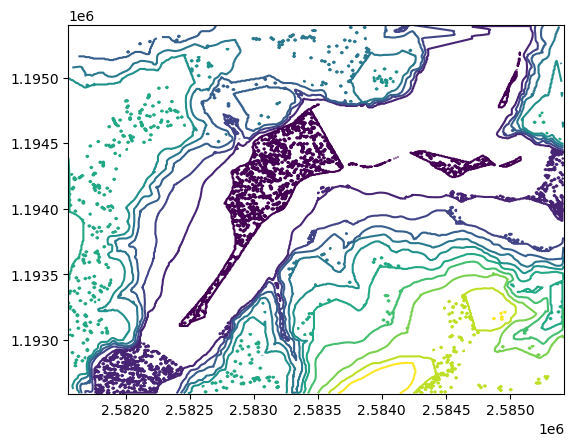

In [9]:
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from shapely.geometry import LineString, mapping
import json

# Load the GeoJSON file
base_path ="/Users/mischabauckhage/Documents/ETH/02_Master/3_Semester/GMP2/gmp2/01_Segmentation/output/"
geojson_path = "old_national_1975_skeleton.geojson"

output_geojson_path = base_path + "interpolated_contours.geojson"

method = 'linear'  # Interpolation method ('linear', 'nearest', 'cubic')

gdf = gpd.read_file(base_path+geojson_path)

# Extract coordinates and heights from contour lines
points = []
values = []
for _, row in gdf.iterrows():
    if isinstance(row.geometry, LineString):
        coords = list(row.geometry.coords)
        height = row['height']  # Make sure 'height' is the attribute in your GeoJSON
        points.extend(coords)
        values.extend([height] * len(coords))

points = np.array(points)
values = np.array(values)

# Create a grid to interpolate onto
min_x, min_y, max_x, max_y = gdf.total_bounds
grid_x, grid_y = np.mgrid[min_x:max_x:500j, min_y:max_y:500j]  # Adjust 500j for resolution

# Perform interpolation (you can try other methods like 'nearest', 'cubic')
grid_z = griddata(points, values, (grid_x, grid_y), method=method)

# Generate new contour lines from interpolated data
contour_levels = np.arange(np.min(values), np.max(values), 10)  # Adjust the step (e.g., 10) for more contours
plt.figure()
contours = plt.contour(grid_x, grid_y, grid_z, levels=contour_levels)

# Convert matplotlib contours to GeoJSON format
new_contours = []
for collection in contours.collections:
    for path in collection.get_paths():
        coords = path.vertices
        line = LineString(coords)
        if line.is_valid:
            new_contours.append({
                "geometry": line,
                "height": collection.get_label(),
            })

print("crs: ", gdf.crs)

# Create a GeoDataFrame from the new contours
new_gdf = gpd.GeoDataFrame(new_contours, crs=gdf.crs, geometry='geometry')





In [14]:
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from shapely.geometry import LineString
import pandas as pd

# Load the GeoJSON file
base_path = "/Users/mischabauckhage/Documents/ETH/02_Master/3_Semester/GMP2/gmp2/01_Segmentation/output/"
geojson_path = "old_national_1975_skeleton.geojson"
output_geojson_path = base_path + "combined_contours.geojson"

method = 'linear'  # Options: 'linear', 'nearest', 'cubic'

# Load the original GeoJSON file
gdf = gpd.read_file(base_path + geojson_path)

# Ensure the GeoDataFrame has a valid CRS (EPSG:2056 for Switzerland)
if gdf.crs is None:
    print("CRS is not set. Assuming EPSG:2056.")
    gdf.set_crs(epsg=2056, inplace=True)
else:
    gdf = gdf.to_crs(epsg=2056)

# Remove any empty geometries
gdf = gdf[~gdf.is_empty]

# Extract coordinates and heights from original contour lines
points = []
values = []
for _, row in gdf.iterrows():
    if isinstance(row.geometry, LineString):
        coords = list(row.geometry.coords)
        height = row['height']  # Ensure 'height' is the correct attribute name
        points.extend(coords)
        values.extend([height] * len(coords))

points = np.array(points)
values = np.array(values)

# Check if points or values are empty
if points.size == 0 or values.size == 0:
    raise ValueError("No valid contour data found for interpolation.")

# Create a grid to interpolate onto
min_x, min_y, max_x, max_y = gdf.total_bounds
grid_x, grid_y = np.mgrid[min_x:max_x:500j, min_y:max_y:500j]  # Adjust 500j for resolution

# Perform interpolation
grid_z = griddata(points, values, (grid_x, grid_y), method=method)

# Generate new contour lines from interpolated data
contour_levels = np.arange(np.min(values), np.max(values), 10)  # Adjust the step size for more contours
plt.figure()
contours = plt.contour(grid_x, grid_y, grid_z, levels=contour_levels)

# Convert new matplotlib contours to GeoDataFrame format
new_contours = []
for level, collection in zip(contours.levels, contours.collections):
    for path in collection.get_paths():
        coords = path.vertices
        line = LineString(coords)
        if line.is_valid:
            new_contours.append({
                "geometry": line,
                "height": level,
            })

# Create a GeoDataFrame from the new interpolated contours
new_gdf = gpd.GeoDataFrame(new_contours, crs='EPSG:2056', geometry='geometry')

# Remove any empty geometries from the new interpolated contours
new_gdf = new_gdf[~new_gdf.is_empty]

# Combine original and new contours
combined_gdf = pd.concat([gdf, new_gdf], ignore_index=True)

# Save the combined contours to a new GeoJSON file
combined_gdf.to_file(output_geojson_path, driver='GeoJSON')
print(f"Combined contours saved to {output_geojson_path}")

# Plot both original and new interpolated contours
fig, ax = plt.subplots(figsize=(10, 8))

# Plot original contours in blue
gdf.plot(ax=ax, color='blue', label='Original Contours', linewidth=1)

# Plot newly interpolated contours in red (dashed)
new_gdf.plot(ax=ax, color='red', linestyle='--', label='Interpolated Contours', linewidth=1)

# Set equal aspect ratio for better visualization
ax.set_aspect('equal')

# Add legend and labels
plt.title('Original and Interpolated Contour Lines (EPSG:2056)')
plt.xlabel('Easting')
plt.ylabel('Northing')
plt.legend()
plt.grid(True)
plt.show()


/Users/mischabauckhage/opt/anaconda3/envs/gis/lib/python3.12/site-packages/numpy/lib/index_tricks.py:184: RuntimeWarning: invalid value encountered in scalar subtract
  step = (kk.stop - start) / float(step - 1)


QhullError: QH6019 qhull input error (qh_scalelast): can not scale last coordinate to [   0,  inf].  Input is cocircular or cospherical.   Use option 'Qz' to add a point at infinity.

While executing:  | qhull d Qc Q12 Qt Qz Qbb
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 1664126972  delaunay  Qcoplanar-keep  Q12-allow-wide  Qtriangulate
  Qz-infinity-point  Qbbound-last  _pre-merge  _zero-centrum  Qinterior-keep
  Pgood  _maxoutside  0


Interpolated raster saved to /Users/mischabauckhage/Documents/ETH/02_Master/3_Semester/GMP2/gmp2/02_DEM/output/height_map_old_national_1975_interpolated.png


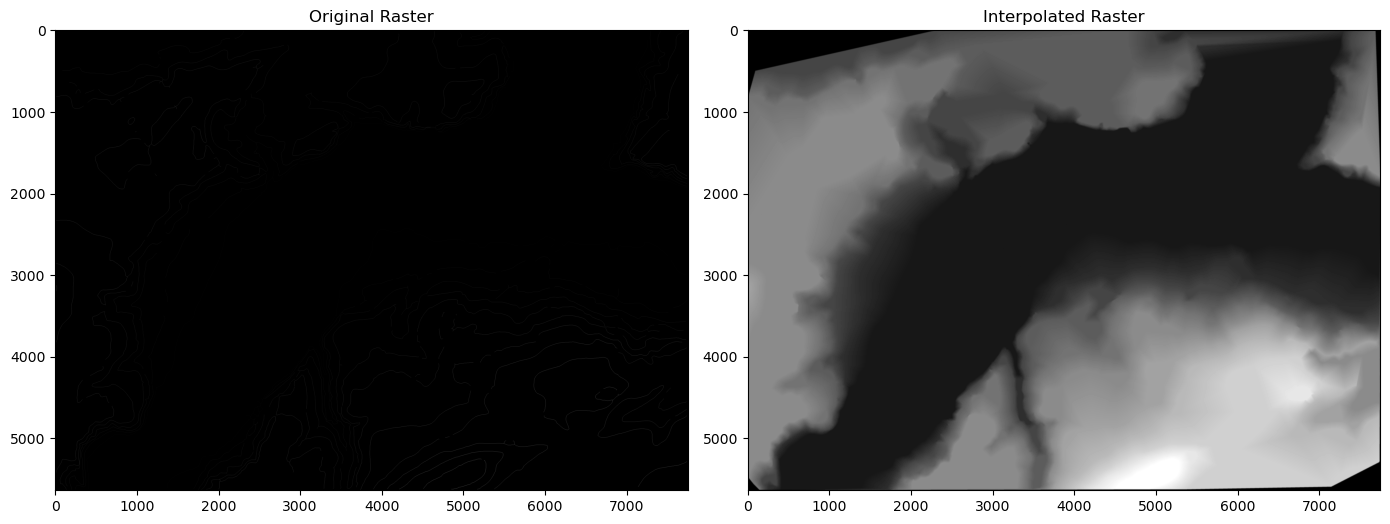

In [15]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from scipy.ndimage import gaussian_filter

# Load the raster file
input_raster_path = "/Users/mischabauckhage/Documents/ETH/02_Master/3_Semester/GMP2/gmp2/02_DEM/output/height_map_old_national_1975.png"
output_raster_path = "/Users/mischabauckhage/Documents/ETH/02_Master/3_Semester/GMP2/gmp2/02_DEM/output/height_map_old_national_1975_interpolated.png"

# Open the raster file
with rasterio.open(input_raster_path) as src:
    raster_data = src.read(1)  # Read the first band
    transform = src.transform  # Affine transformation for georeferencing
    crs = src.crs  # Coordinate Reference System (CRS)
    width = src.width
    height = src.height

# Identify the pixels that are non-zero (representing contour lines)
y_indices, x_indices = np.indices(raster_data.shape)
non_zero_mask = raster_data > 0
non_zero_x = x_indices[non_zero_mask]
non_zero_y = y_indices[non_zero_mask]
non_zero_values = raster_data[non_zero_mask]

# Perform interpolation to fill in the gaps (using griddata)
interpolated_raster = griddata(
    (non_zero_x, non_zero_y), non_zero_values, 
    (x_indices, y_indices), method='linear', fill_value=0
)

# Optionally, apply a Gaussian filter to smooth the interpolated raster
smoothed_raster = gaussian_filter(interpolated_raster, sigma=3)

# Save the interpolated raster to a new GeoTIFF file
with rasterio.open(
    output_raster_path,
    'w',
    driver='GTiff',
    height=smoothed_raster.shape[0],
    width=smoothed_raster.shape[1],
    count=1,
    dtype='float32',  # Use float32 for continuous values
    crs=crs,
    transform=transform
) as dst:
    dst.write(smoothed_raster, 1)

print(f"Interpolated raster saved to {output_raster_path}")

# Plot the original and interpolated raster
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot the original raster (non-interpolated)
axes[0].imshow(raster_data, cmap='gray', origin='upper')
axes[0].set_title('Original Raster')

# Plot the interpolated raster
axes[1].imshow(smoothed_raster, cmap='gray', origin='upper')
axes[1].set_title('Interpolated Raster')

plt.tight_layout()
plt.show()


Interpolated raster saved to /Users/mischabauckhage/Documents/ETH/02_Master/3_Semester/GMP2/gmp2/02_DEM/output/height_map_old_national_1975_interpolated.tif
Converted /Users/mischabauckhage/Documents/ETH/02_Master/3_Semester/GMP2/gmp2/02_DEM/output/height_map_old_national_1975_interpolated.tif to /Users/mischabauckhage/Documents/ETH/02_Master/3_Semester/GMP2/gmp2/02_DEM/output/height_map_old_national_1975_interpolated.png


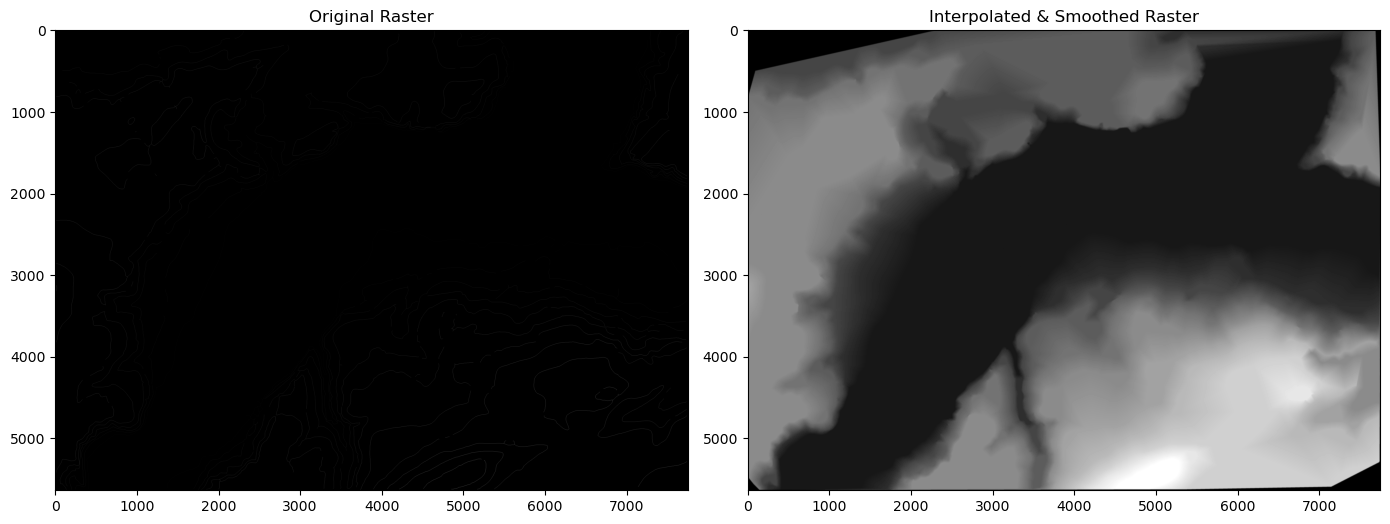

In [29]:
import rasterio
import numpy as np
from scipy.interpolate import griddata
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
from PIL import Image


# File paths
input_raster_path = "/Users/mischabauckhage/Documents/ETH/02_Master/3_Semester/GMP2/gmp2/02_DEM/output/height_map_old_national_1975.png"
output_raster_path = "/Users/mischabauckhage/Documents/ETH/02_Master/3_Semester/GMP2/gmp2/02_DEM/output/height_map_old_national_1975_interpolated.tif"

# Step 1: Open the input raster file
with rasterio.open(input_raster_path) as src:
    raster_data = src.read(1)  # Read the first band (grayscale)
    transform = src.transform  # Preserve the original affine transform
    crs = src.crs  # Preserve the original CRS
    width = src.width
    height = src.height

# Step 2: Identify the pixels that are non-zero (representing contour lines)
y_indices, x_indices = np.indices(raster_data.shape)
non_zero_mask = raster_data > 0
non_zero_x = x_indices[non_zero_mask]
non_zero_y = y_indices[non_zero_mask]
non_zero_values = raster_data[non_zero_mask]

# Step 3: Perform interpolation to fill in the gaps using griddata
interpolated_raster = griddata(
    (non_zero_x, non_zero_y), non_zero_values,
    (x_indices, y_indices), method='linear', fill_value=0
)

# Optional: Apply a Gaussian filter to smooth the interpolated raster
smoothed_raster = gaussian_filter(interpolated_raster, sigma=3)

# Step 4: Save the interpolated raster to a new GeoTIFF file with one band
with rasterio.open(
    output_raster_path,
    'w',
    driver='GTiff',
    height=smoothed_raster.shape[0],
    width=smoothed_raster.shape[1],
    count=1,  # Single band
    dtype='float32',  # Use float32 for continuous values
    crs=crs,  # Use the original CRS
    transform=transform  # Use the original transform
) as dst:
    dst.write(smoothed_raster, 1)  # Write the smoothed raster to the first band

print(f"Interpolated raster saved to {output_raster_path}")




def convert_tif_to_png(input_tif_path, output_png_path):
    # Open the TIFF file
    with Image.open(input_tif_path) as img:
        # Convert the image to a mode supported by PNG
        if img.mode == 'F':
            img = img.convert('L')  # Convert to grayscale
        elif img.mode not in ['L', 'RGB']:
            img = img.convert('RGB')  # Convert to RGB if not already in a supported mode
        # Save the image as PNG
        img.save(output_png_path, "PNG")
        print(f"Converted {input_tif_path} to {output_png_path}")

# Example usage
convert_tif_to_png(output_raster_path, output_raster_path.replace('.tif', '.png'))

# Step 5: Plot the original and interpolated raster for comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot the original raster (non-interpolated)
axes[0].imshow(raster_data, cmap='gray', origin='upper')
axes[0].set_title('Original Raster')

# Plot the interpolated raster
axes[1].imshow(smoothed_raster, cmap='gray', origin='upper')
axes[1].set_title('Interpolated & Smoothed Raster')

plt.tight_layout()
plt.show()


In [30]:
from PIL import Image

input_png_path = "/Users/mischabauckhage/Documents/ETH/02_Master/3_Semester/GMP2/gmp2/02_DEM/output/final_dem_1975.png"
input_png_path = "/Users/mischabauckhage/Documents/ETH/02_Master/3_Semester/GMP2/gmp2/02_DEM/output/height_map_old_national_1975_interpolated.png"

def extract_extent(input_png_path, output_png_path, left, upper, right, lower):
    # Open the PNG file
    with Image.open(input_png_path) as img:
        # Crop the image to the specified extent
        cropped_img = img.crop((left, upper, right, lower))
        # Save the cropped image
        cropped_img.save(output_png_path)
        print(f"Extracted extent and saved to {output_png_path}")

# Example usage
left, upper, right, lower = 0, 0, 5000, 5000
output_cropped_png_path = "/Users/mischabauckhage/Documents/ETH/02_Master/3_Semester/GMP2/gmp2/02_DEM/output/height_map_old_national_1975_interpolated_cropped.png"
extract_extent(input_png_path, output_cropped_png_path, left, upper, right, lower)

Extracted extent and saved to /Users/mischabauckhage/Documents/ETH/02_Master/3_Semester/GMP2/gmp2/02_DEM/output/height_map_old_national_1975_interpolated_cropped.png


In [22]:
from PIL import Image

# Define the path to the PNG file
png_path = "/Users/mischabauckhage/Documents/ETH/02_Master/3_Semester/GMP2/gmp2/02_DEM/output/final_dem_1975.png"

# Open the PNG file
with Image.open(png_path) as img:
    # Print basic information
    print(f"Filename: {img.filename}")
    print(f"Format: {img.format}")
    print(f"Mode: {img.mode}")
    print(f"Size: {img.size}")
    print(f"Width: {img.width}")
    print(f"Height: {img.height}")
    print(f"Info: {img.info}")

    # Convert to numpy array to get the shape
    img_array = np.array(img)
    print(f"Shape: {img_array.shape}")

Filename: /Users/mischabauckhage/Documents/ETH/02_Master/3_Semester/GMP2/gmp2/02_DEM/output/final_dem_1975.png
Format: PNG
Mode: L
Size: (8192, 6144)
Width: 8192
Height: 6144
Info: {}
Shape: (6144, 8192)


In [27]:
from PIL import Image

# Define the path to the PNG file
png_path = "/Users/mischabauckhage/Documents/ETH/02_Master/3_Semester/GMP2/gmp2/02_DEM/output/height_map_old_national_1975_interpolated_cropped.png"

# Open the PNG file
with Image.open(png_path) as img:
    # Print basic information
    print(f"Filename: {img.filename}")
    print(f"Format: {img.format}")
    print(f"Mode: {img.mode}")
    print(f"Size: {img.size}")
    print(f"Width: {img.width}")
    print(f"Height: {img.height}")
    print(f"Info: {img.info}")

    # Convert to numpy array to get the shape
    img_array = np.array(img)
    print(f"Shape: {img_array.shape}")

Filename: /Users/mischabauckhage/Documents/ETH/02_Master/3_Semester/GMP2/gmp2/02_DEM/output/height_map_old_national_1975_interpolated_cropped.png
Format: PNG
Mode: L
Size: (5000, 5000)
Width: 5000
Height: 5000
Info: {}
Shape: (5000, 5000)


In [25]:
from PIL import Image

def convert_tif_to_png(input_tif_path, output_png_path):
    # Open the TIFF file
    with Image.open(input_tif_path) as img:
        # Convert the image to a mode supported by PNG
        if img.mode == 'F':
            img = img.convert('L')  # Convert to grayscale
        elif img.mode not in ['L', 'RGB']:
            img = img.convert('RGB')  # Convert to RGB if not already in a supported mode
        # Save the image as PNG
        img.save(output_png_path, "PNG")
        print(f"Converted {input_tif_path} to {output_png_path}")

# Example usage
input_tif_path = "/Users/mischabauckhage/Documents/ETH/02_Master/3_Semester/GMP2/gmp2/02_DEM/output/height_map_old_national_1975_interpolated_cropped.tif"
output_png_path = "/Users/mischabauckhage/Documents/ETH/02_Master/3_Semester/GMP2/gmp2/02_DEM/output/height_map_old_national_1975_interpolated_cropped.png"
convert_tif_to_png(input_tif_path, output_png_path)

Converted /Users/mischabauckhage/Documents/ETH/02_Master/3_Semester/GMP2/gmp2/02_DEM/output/height_map_old_national_1975_interpolated_cropped.tif to /Users/mischabauckhage/Documents/ETH/02_Master/3_Semester/GMP2/gmp2/02_DEM/output/height_map_old_national_1975_interpolated_cropped.png


In [33]:
1000/(3874/2826)

729.4785751161589

In [1]:
import json

def get_min_max_height(geojson_path):
    """
    Reads a GeoJSON file and extracts the minimum and maximum height values.

    Parameters:
    - geojson_path (str): Path to the GeoJSON file.

    Returns:
    - Tuple (min_height, max_height): Minimum and maximum height values.
    """
    try:
        # Load the GeoJSON file
        with open(geojson_path, 'r') as file:
            geojson_data = json.load(file)

        # Ensure the GeoJSON has features
        if 'features' not in geojson_data or not geojson_data['features']:
            raise ValueError("The GeoJSON file does not contain any features.")

        # Extract height values from features
        heights = []
        for feature in geojson_data['features']:
            # Assume height is stored in the 'properties' section under a key like 'height'
            # Adjust the key as per your GeoJSON structure
            height = feature.get('properties', {}).get('height')
            if height is not None:
                heights.append(height)

        # Check if we found any heights
        if not heights:
            raise ValueError("No height values found in the GeoJSON file.")

        # Calculate min and max
        min_height = min(heights)
        max_height = max(heights)

        return min_height, max_height

    except Exception as e:
        print(f"Error processing GeoJSON file: {e}")
        return None, None

# Example usage
geojson_file = "/Volumes/T7 Shield/GMP_Data/processed_data/00_Segmentation/1899/skeleton_1899_heights.geojson"
min_height, max_height = get_min_max_height(geojson_file)
if min_height is not None and max_height is not None:
    print(f"Minimum height: {min_height}")
    print(f"Maximum height: {max_height}")


Minimum height: 490.0
Maximum height: 610.0


In [6]:
import json
import os

def get_min_max_height(geojson_path):
    """
    Reads a GeoJSON file and extracts the minimum and maximum height values.

    Parameters:
    - geojson_path (str): Path to the GeoJSON file.

    Returns:
    - Tuple (min_height, max_height): Minimum and maximum height values.
    """
    try:
        # Load the GeoJSON file
        with open(geojson_path, 'r') as file:
            geojson_data = json.load(file)

        # Ensure the GeoJSON has features
        if 'features' not in geojson_data or not geojson_data['features']:
            raise ValueError("The GeoJSON file does not contain any features.")

        # Extract height values from features
        heights = []
        for feature in geojson_data['features']:
            # Assume height is stored in the 'properties' section under a key like 'height'
            # Adjust the key as per your GeoJSON structure
            height = feature.get('properties', {}).get('height')
            if height is not None:
                heights.append(height)

        # Check if we found any heights
        if not heights:
            raise ValueError("No height values found in the GeoJSON file.")

        # Calculate min and max
        min_height = min(heights)
        max_height = max(heights)

        return min_height, max_height

    except Exception as e:
        print(f"Error processing {geojson_path}: {e}")
        return None, None

def process_geojsons(input_folder, output_json_path):
    """
    Processes all GeoJSON files in a folder, calculates the min and max height for each file,
    and stores the results in a JSON file.

    Parameters:
    - input_folder (str): Path to the folder containing GeoJSON files.
    - output_json_path (str): Path to save the output JSON file.
    """
    results = {}

    # Walk through all subdirectories
    for root, _, files in os.walk(input_folder):
        for file_name in files:
            if file_name.endswith('.geojson') and "height" in file_name and not file_name.startswith('._'):  # Only process relevant GeoJSON files
                year = os.path.splitext(file_name)[0]  # Use the file name (without extension) as the key
                geojson_path = os.path.join(root, file_name)
                
                # Get min and max heights
                min_height, max_height = get_min_max_height(geojson_path)
                if min_height is not None and max_height is not None:
                    results[year] = {
                        "min_height": min_height,
                        "max_height": max_height,
                        "difference": max_height - min_height,
                        "difference_with_rivers": max_height - min_height + 4  # Add 4 for rivers
                    }
            else:
                print(f"Skipping file: {file_name}")
    
    # Save results to a JSON file
    with open(output_json_path, 'w') as output_file:
        json.dump(results, output_file, indent=4)
    print(f"Results saved to {output_json_path}")

# Example usage
input_folder = "/Volumes/T7 Shield/GMP_Data/processed_data/00_Segmentation"  # Replace with the path to your folder
output_json = "/Volumes/T7 Shield/GMP_Data/processed_data/00_Segmentation/height_statistics.json"  # Replace with your desired output file name
process_geojsons(input_folder, output_json)


Skipping file: ._1975
Skipping file: ._1899
Skipping file: ._1912
Skipping file: ._1930
Skipping file: ._1939
Skipping file: height_statistics.json
Skipping file: skeleton_1899.png
Skipping file: skeleton_1899.geojson
Skipping file: ._skeleton_1899_heights.geojson
Skipping file: skeleton_1899_heights.tif
Skipping file: skeleton_1904.geojson
Skipping file: skeleton_1912.geojson
Skipping file: ._skeleton_1912_heights.geojson
Skipping file: skeleton_1912_heights.tif
Skipping file: skeleton_1930.png
Skipping file: skeleton_1930.geojson
Skipping file: ._skeleton_1930_heights.geojson
Skipping file: skeleton_1930_heights.tif
Skipping file: skeleton_1939.png
Skipping file: skeleton_1939_heights.tif
Skipping file: skeleton_1987.png
Skipping file: skeleton_1987.geojson
Skipping file: skeleton_1975.geojson
Skipping file: ._skeleton_1975.geojson
Skipping file: ._skeleton_1975.png
Skipping file: skeleton_1975.png
Skipping file: ._skeleton_1975_heights.geojson
Skipping file: skeleton_1975_heights.ti